In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install pytorch-lightning wandb matplotlib scipy
!pip install torchvision tqdm
!pip install rsatoolbox==0.1.5 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 55.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import warnings
from pathlib import Path

In [7]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

In [84]:
def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation' is pearson, 'euclidean', 'spearman', 'cosine'

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]


        feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict

def plot_rdms(rdms_dict, figsize_per_plot=(3.5, 3), cmap='viridis'):
    """
    Plot RDMs for visualization

    Args:
        rdms_dict: Dictionary of RDMs by layer name
        figsize_per_plot: Size of each subplot
        cmap: Colormap for visualization

    revise so all subplots share the same color scale (legend range) based on the global min and max across all RDMs
    """

    n_layers = len(rdms_dict)
    cols = min(3, n_layers)  # Max 3 columns
    rows = (n_layers + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols,
                            figsize=(cols * figsize_per_plot[0], rows * figsize_per_plot[1]))

    if n_layers == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()

    # Compute global vmin and vmax across all RDMs
    all_values = np.concatenate([rdm.flatten() for rdm in rdms_dict.values()])
    vmin, vmax = all_values.min(), all_values.max()

    for idx, (layer_name, rdm) in enumerate(rdms_dict.items()):
        ax = axes[idx]

        # Plot RDM
        im = ax.imshow(rdm, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
        ax.set_title(f'{layer_name}\n({rdm.shape[0]}×{rdm.shape[1]})')
        ax.set_xlabel('Stimulus')
        ax.set_ylabel('Stimulus')

        # Add colorbar
        plt.colorbar(im, ax=ax, shrink=0.8)

    # Hide empty subplots
    for idx in range(n_layers, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.suptitle('Representational Dissimilarity Matrices (RDMs)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()

## labels

In [44]:
labels = np.load('drive/MyDrive/Neuromatch_25/labels_30x30.npy')
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

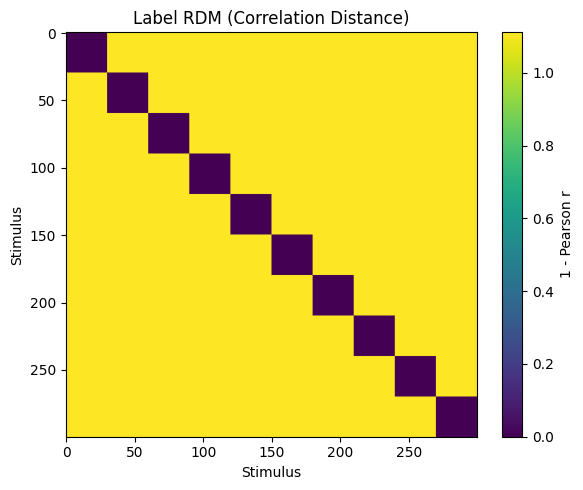

In [45]:
import torch
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

def compute_label_rdm_correlation(labels):
    """
    Compute a correlation-distance RDM from one-hot encoded labels.
    Equivalent to how feature RDMs are calculated.

    Args:
        labels (torch.Tensor or np.ndarray): Class labels (N,)

    Returns:
        label_rdm (np.ndarray): RDM of shape (N, N)
    """
    labels_np = labels.cpu().numpy() if torch.is_tensor(labels) else labels
    labels_np = labels_np.reshape(-1, 1)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    labels_onehot = encoder.fit_transform(labels_np)

    # Compute Pearson correlation distance: 1 - r
    label_rdm = squareform(pdist(labels_onehot, metric='correlation'))
    return label_rdm

def plot_label_rdm(label_rdm, title='Label RDM (Correlation Distance)', figsize=(6, 5), cmap='viridis'):
    plt.figure(figsize=figsize)
    plt.imshow(label_rdm, cmap=cmap, aspect='auto')
    plt.title(title)
    plt.xlabel('Stimulus')
    plt.ylabel('Stimulus')
    plt.colorbar(label='1 - Pearson r')
    plt.tight_layout()
    plt.show()

# Usage
label_rdm_corr = compute_label_rdm_correlation(labels)
plot_label_rdm(label_rdm_corr)


## CNN

In [12]:
cnn_layer5_rdms = np.load('drive/MyDrive/Neuromatch_25/rdms_by_layer.npz')

# List all layers stored
print("Layers saved:", cnn_layer5_rdms.files)

# Access a specific RDM, e.g. for 'softmax'
softmax_rdm = cnn_layer5_rdms['fc1']

Layers saved: ['x', 'conv1.0', 'conv1.1', 'conv1.2', 'conv2.0', 'conv2.1', 'conv2.2', 'conv3.0', 'conv3.1', 'conv4.0', 'conv4.1', 'conv5.0', 'conv5.1', 'conv5.2', 'fc1', 'fc2', 'fc3', 'softmax']


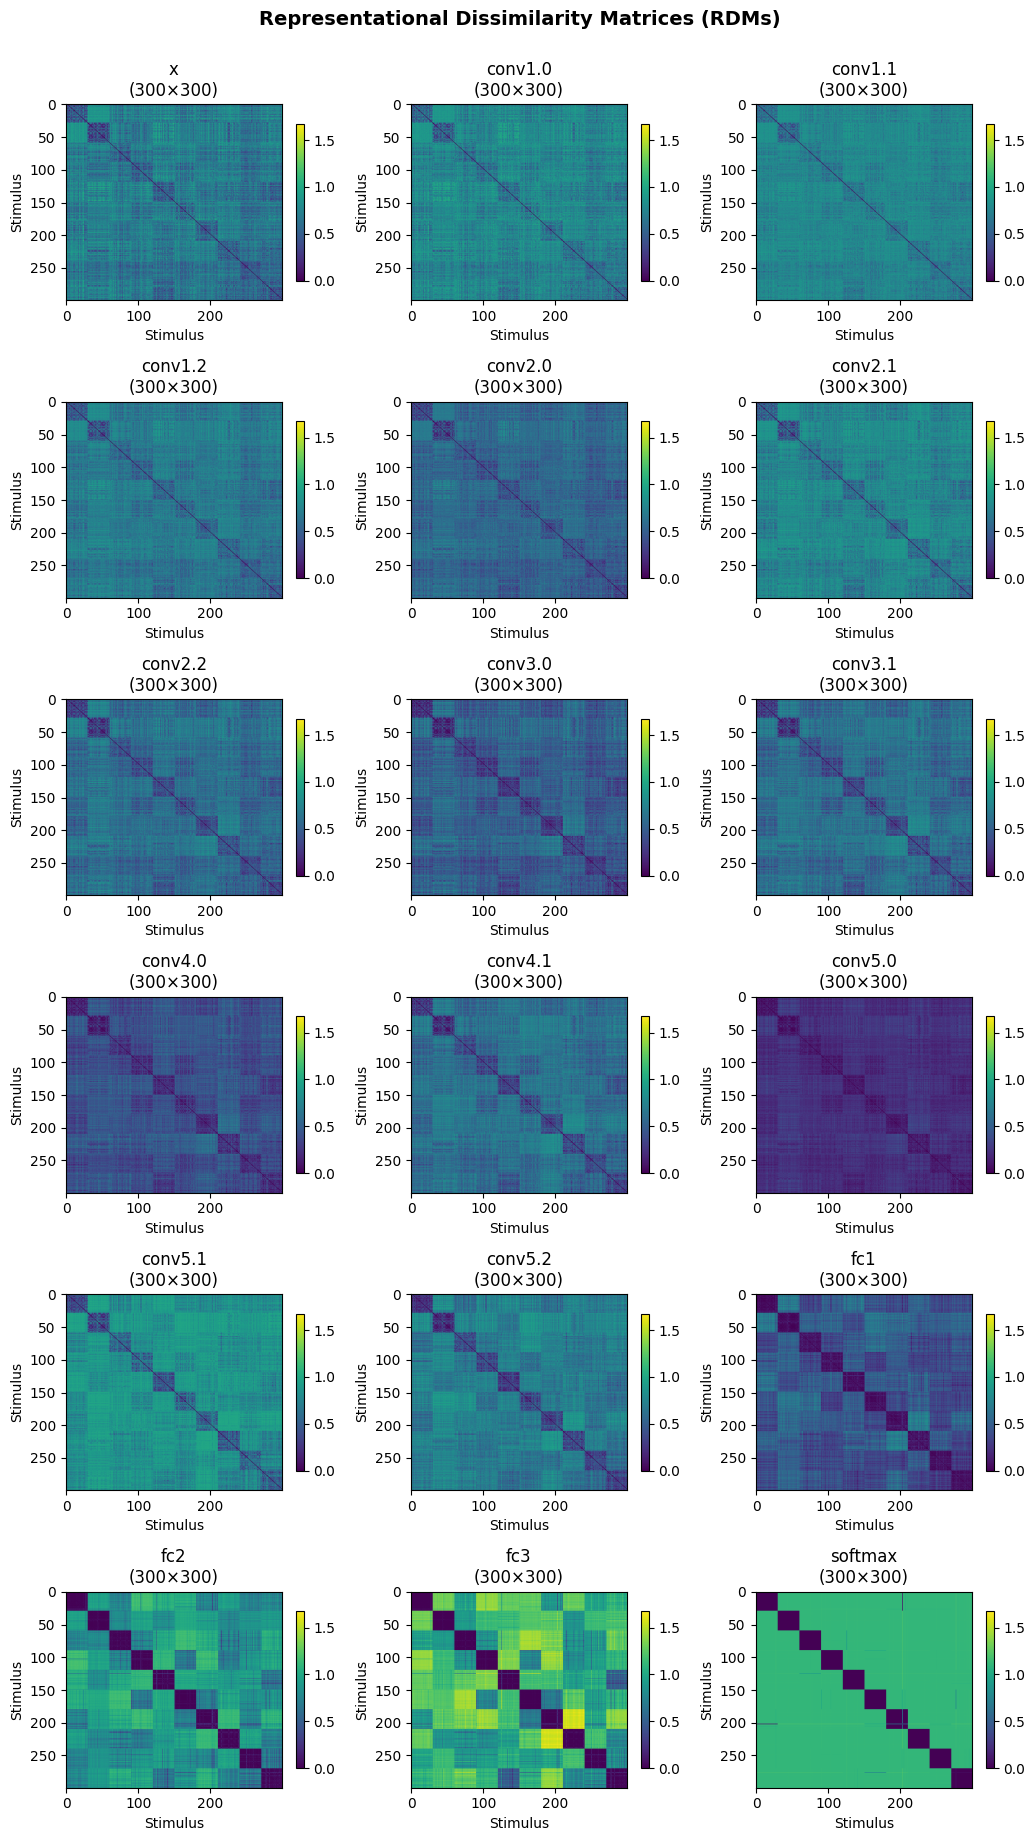

In [46]:
plot_rdms(cnn_layer5_rdms)

## SNN

In [18]:
snn_rdms = np.load('drive/MyDrive/Neuromatch_25/SNN_rdms.npz')

# List all layers stored
print("Layers saved:", snn_rdms.files)

# Access a specific RDM, e.g. for 'softmax'
# softmax_rdm = cnn_layer5_rdms['fc1']

Layers saved: ['fc1', 'lif1', 'fc2', 'lif2']


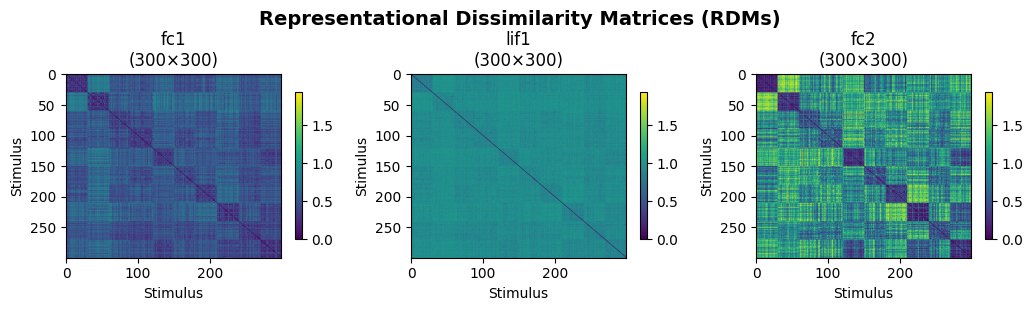

In [85]:
plot_rdms(snn_rdms_dict)

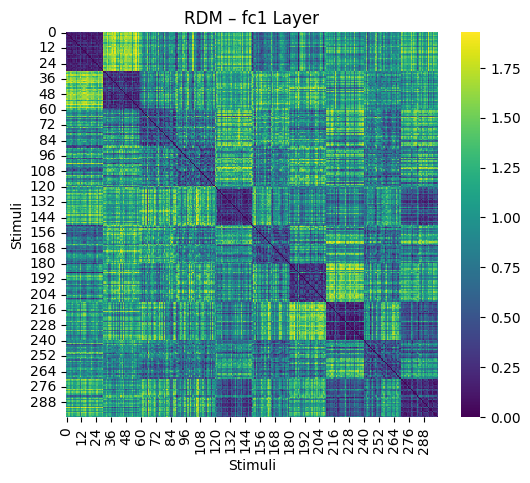

In [76]:
import seaborn as sns

fc1_rdm = snn_rdms['fc2']
plt.figure(figsize=(6,5))
sns.heatmap(fc1_rdm, cmap='viridis')
plt.title("RDM – fc1 Layer")
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
plt.show()

In [69]:
snn_rdms['lif2']

array([[ 0.00000000e+00,             nan, -1.19209290e-07, ...,
         1.11111116e+00,  1.11111116e+00,             nan],
       [            nan,  0.00000000e+00,             nan, ...,
                    nan,             nan,             nan],
       [-1.19209290e-07,             nan,  0.00000000e+00, ...,
         1.11111116e+00,  1.11111116e+00,             nan],
       ...,
       [ 1.11111116e+00,             nan,  1.11111116e+00, ...,
         0.00000000e+00,  5.96046448e-08,             nan],
       [ 1.11111116e+00,             nan,  1.11111116e+00, ...,
         5.96046448e-08,  0.00000000e+00,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,  0.00000000e+00]])

## RSA

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from rsatoolbox.rdm import RDMs, concat
from sklearn import manifold
from sklearn.metrics import pairwise_distances
import torch
import torch.nn.functional as F

def rep_path_from_rdms(model_rdms, model_colors, rdm_comp_method='cosine', labels=None):
    """
    Visualizes representational geometry paths from precomputed RDMs of each model.

    Inputs:
    - model_rdms (dict): Dict of {model_name: {layer_name: RDM matrix (2D numpy array)}}.
    - model_colors (dict): Dict mapping model names to colors for plotting.
    - rdm_comp_method (str): Method to compare RDMs: 'cosine', 'corr', or 'spearman'.
    - labels (1D array-like, optional): Ground-truth labels to compute label RDM.
    """
    path_len = []
    path_colors = []
    rdms_list = []
    ax_ticks = []
    tick_colors = []
    model_names = list(model_rdms.keys())

    for m, model_name in enumerate(model_names):
        layer_dict = model_rdms[model_name]
        layer_names = list(layer_dict.keys())

        # Force conversion to NumPy arrays
        rdm_matrices = [np.array(layer_dict[layer]) for layer in layer_names]
        rdm_array = np.stack(rdm_matrices, axis=0)  # shape: (n_layers, 300, 300)

        rdm_objs = RDMs(dissimilarities=rdm_array, rdm_descriptors={'layer': layer_names})

        path_colors.append(model_colors[model_name])
        path_len.append(len(layer_names))
        ax_ticks.append(layer_names)
        tick_colors.append([model_colors[model_name]] * len(layer_names))
        rdms_list.append(rdm_objs)



    # Optional: Add ground-truth label RDM
    if labels is not None:
        if not torch.is_tensor(labels):
            labels = torch.tensor(labels)
        onehot_labels = F.one_hot(labels).float()
        label_rdm = pairwise_distances(onehot_labels, metric='euclidean')  # 0 if same class
        # label_rdm_obj = RDMs(dissimilarities=[label_rdm], rdm_descriptors={'layer': ['labels']})
        label_rdm_obj = RDMs(dissimilarities=np.expand_dims(label_rdm, axis=0), rdm_descriptors={'layer': ['labels']})
        rdms_list.append(label_rdm_obj)
        ax_ticks.append(['labels'])
        tick_colors.append(['magenta'])

    # Flatten ticks and colors
    ax_ticks = [tick for group in ax_ticks for tick in group]
    tick_colors = [color for group in tick_colors for color in group]

    # Concatenate all RDMs
    rdms = concat(rdms_list)
    rdm_vectors = rdms.get_vectors()
    num_rdms = rdm_vectors.shape[0]
    rdms_comp = np.zeros((num_rdms, num_rdms))

    for i in range(num_rdms):
        for j in range(i, num_rdms):
            if rdm_comp_method == 'spearman':
                from scipy.stats import spearmanr
                val, _ = spearmanr(rdm_vectors[i], rdm_vectors[j])
            elif rdm_comp_method == 'corr':
                from scipy.stats import pearsonr
                val, _ = pearsonr(rdm_vectors[i], rdm_vectors[j])
            elif rdm_comp_method == 'cosine':
                a = rdm_vectors[i]
                b = rdm_vectors[j]
                val = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
                val = 1 - val  # Convert to dissimilarity
            else:
                raise ValueError(f"Unsupported rdm_comp_method: {rdm_comp_method}")
            rdms_comp[i, j] = val
            rdms_comp[j, i] = val

    if rdm_comp_method in ['spearman', 'corr']:
        rdms_comp = 1 - rdms_comp  # similarity → dissimilarity

    rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)
    rdms_comp = (rdms_comp + rdms_comp.T) / 2.0  # Symmetrize

    # MDS projection
    transformer = manifold.MDS(n_components=2, dissimilarity='precomputed', max_iter=1000, n_init=10)
    dims = transformer.fit_transform(rdms_comp)
    idx_labels = len(dims) - 1 if labels is not None else None

    # Compute path lengths
    path_len = np.insert(np.cumsum(path_len), 0, 0)

    # === Plot 1: Dissimilarity matrix ===
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    im = ax1.imshow(rdms_comp, cmap='viridis_r')
    ax1.set_title('Dissimilarity Between Layer RDMs')
    ax1.set_xticks(np.arange(len(ax_ticks)))
    ax1.set_xticklabels(ax_ticks, rotation=90, fontsize=6)
    ax1.set_yticks(np.arange(len(ax_ticks)))
    ax1.set_yticklabels(ax_ticks, fontsize=6)
    for label, tick in zip(tick_colors, ax1.xaxis.get_ticklabels()):
        tick.set_color(label)
    for label, tick in zip(tick_colors, ax1.yaxis.get_ticklabels()):
        tick.set_color(label)
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

    # === Plot 2: MDS Path Plot ===
    ax2 = fig.add_subplot(gs[0, 1])
    for i in range(len(model_names)):
        path_indices = np.arange(path_len[i], path_len[i + 1])
        ax2.plot(dims[path_indices, 0], dims[path_indices, 1], '-o', color=path_colors[i], label=model_names[i])
    if labels is not None:
        # ax2.plot(dims[idx_labels, 0], dims[idx_labels, 1], color='magenta', marker='*', markersize=10, label='labels')
        ax2.scatter(dims[idx_labels, 0], dims[idx_labels, 1], color='magenta', marker='*', s=100, label='labels')

    ax2.set_title('Representational Geometry Path (MDS)')
    ax2.set_xlabel('Dimension 1')
    ax2.set_ylabel('Dimension 2')
    ax2.axis('equal')
    ax2.legend(fontsize=8)
    fig.tight_layout()
    plt.show()


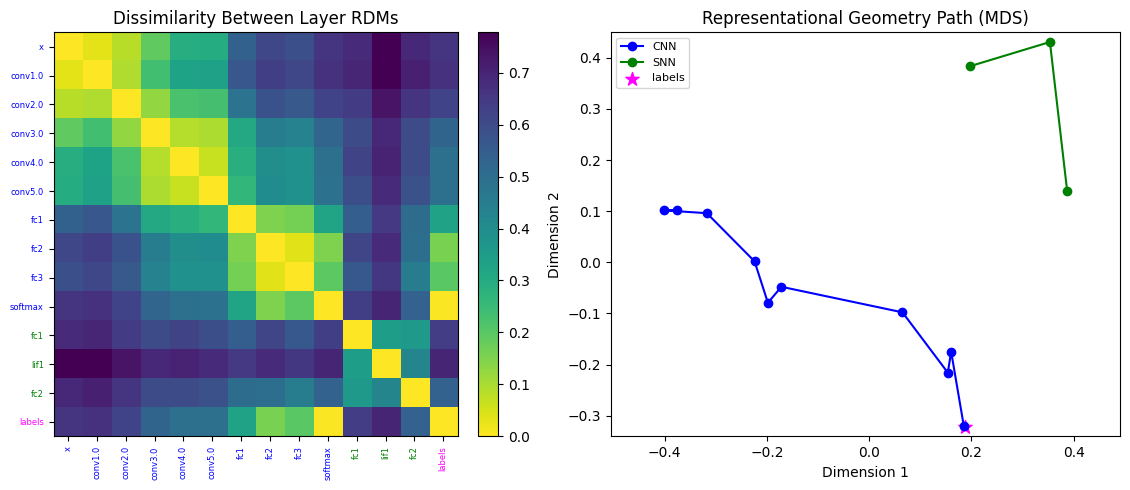

In [78]:
# Load your precomputed RDMs
cnn_rdms_dict =  {k: v for k, v in cnn_layer5_rdms.items() if k not in
    ['conv1.1', 'conv1.2', 'conv2.1', 'conv2.2','conv3.1', 'conv4.1', 'conv5.1','conv5.2']} #dict(cnn_layer5_rdms)
snn_rdms_dict = {k: v for k, v in snn_rdms.items() if k not in
    ['lif2']}#dict(snn_rdms)

model_rdms = {
    'CNN': cnn_rdms_dict,
    'SNN': snn_rdms_dict
}

model_colors = {
    'CNN': 'blue',
    'SNN': 'green'
}


# Call the function
rep_path_from_rdms(model_rdms, model_colors, rdm_comp_method='corr', labels=labels)


In [59]:
for k, v in snn_rdms.items():
    print(f"{k}: {np.array(v).shape}")


fc1: (300, 300)
lif1: (300, 300)
fc2: (300, 300)
lif2: (300, 300)
